In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import FunctionTransformer

#Load in the resampled dataset
df = pd.read_csv('data/processed/hourly_pollutionpatterns.csv').set_index('DATETIME')

# Including harmonic signals
def sin_encoder(period):
        return FunctionTransformer(lambda x: np.sin((2 * np.pi* x)/period))

def cos_encoder(period):

    return FunctionTransformer(lambda x: np.cos((2 * np.pi* x)/period))

def adding_remaining_features(df):

    df.index = pd.to_datetime(df.index, utc=True)

    pollutants = ["TOC", "TN", "TP", "SS"]

    df["sine"] = sin_encoder(24).fit_transform(df.index.hour)
    df["cosine"] = cos_encoder(24).fit_transform(df.index.hour)

    # Including day of week
    df["is_weekend"] = df.index.dayofweek.isin([5, 6]).astype(int)

    # Taking the logarithm of Pollutants
    logcn = lambda x: f"log{x}"
    logpollutants = []
    for p in pollutants:
        cn = logcn(p)
        df[cn] = np.log(1 + df[p].divide(df[p].max()))
        logpollutants.append(cn)

    return df

#The function
def dataProcessing_Chunks(inputdf,features,hours_ahead,hours_behind):
    for feature in features:
        for i in range(1,hours_ahead+1,1):
            inputdf[f'{feature}+{i}'] = inputdf[f'{feature}'].shift(-i)
    for feature in features:
        for i in range(1,hours_behind+1,1):
            inputdf[f'{feature}-{i}'] = inputdf[f'{feature}'].shift(i)   
    inputdf.dropna(inplace=True)
    return inputdf
  
#Use the function
fetures_shift = ['TOC','TN','TP','SS','Rain']
df_chunks = dataProcessing_Chunks(df,fetures_shift,6,6)
df_chunks = adding_remaining_features(df_chunks)

In [2]:
def split_dataset(inputdf,features_drop,hours_ahead):
    holder = []
    for feature in features_drop:
        for i in range(1,hours_ahead+1,1):
            holder.append(f'{feature}+{i}')
    X1 = inputdf.drop(holder, axis=1)
    y1 = inputdf[holder]
    return X1, y1

fetures_drop = ['TOC','TN','TP','SS']
X, y = split_dataset(df_chunks,fetures_drop,6)

In [3]:
X.reset_index(inplace=True)
X = X.drop(['DATETIME'],axis=1)

In [4]:
X.columns

Index(['TOC', 'TN', 'TP', 'SS', 'Flow', 'Bypass', 'Rain', 'Rain+1', 'Rain+2',
       'Rain+3', 'Rain+4', 'Rain+5', 'Rain+6', 'TOC-1', 'TOC-2', 'TOC-3',
       'TOC-4', 'TOC-5', 'TOC-6', 'TN-1', 'TN-2', 'TN-3', 'TN-4', 'TN-5',
       'TN-6', 'TP-1', 'TP-2', 'TP-3', 'TP-4', 'TP-5', 'TP-6', 'SS-1', 'SS-2',
       'SS-3', 'SS-4', 'SS-5', 'SS-6', 'Rain-1', 'Rain-2', 'Rain-3', 'Rain-4',
       'Rain-5', 'Rain-6', 'sine', 'cosine', 'is_weekend', 'logTOC', 'logTN',
       'logTP', 'logSS'],
      dtype='object')

In [5]:
y.columns

Index(['TOC+1', 'TOC+2', 'TOC+3', 'TOC+4', 'TOC+5', 'TOC+6', 'TN+1', 'TN+2',
       'TN+3', 'TN+4', 'TN+5', 'TN+6', 'TP+1', 'TP+2', 'TP+3', 'TP+4', 'TP+5',
       'TP+6', 'SS+1', 'SS+2', 'SS+3', 'SS+4', 'SS+5', 'SS+6'],
      dtype='object')

In [6]:
X_train = X[:20000]
X_test = X[20000:26683]
y_train = y[:20000]
y_test = y[20000:26683]

In [7]:
import xgboost as xgb

# Create the XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the XGBoost model
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [8]:
# from sklearn.model_selection import GridSearchCV

# gsc = GridSearchCV(
#             estimator=xgb.XGBRegressor(),
#             param_grid={"learning_rate": (0.05, 0.10, 0.15),
#                         "max_depth": [ 3, 4, 5, 6, 8],
#                         "min_child_weight": [ 1, 3, 5, 7],
#                         "gamma":[ 0.0, 0.1, 0.2],
#                         "colsample_bytree":[ 0.3, 0.4],},
#             cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

# grid_result = MultiOutputRegressor(gsc).fit(X_train, y_train)

# self.best_params = grid_result.estimators_[0].best_params_

In [9]:
xgb_y_pred = xgb_model.predict(X_test)

In [10]:
dfxgb_y_pred = pd.DataFrame(xgb_y_pred, columns=y_train.columns)
dfxgb_y_pred

,TOC+1,TOC+2,TOC+3,TOC+4,TOC+5,TOC+6,TN+1,TN+2,TN+3,TN+4,...,TP+3,TP+4,TP+5,TP+6,SS+1,SS+2,SS+3,SS+4,SS+5,SS+6
0,163.502670,171.825500,152.936676,160.200409,163.140442,164.528717,41.412926,41.155346,37.794529,38.398808,...,11.451838,9.839386,8.807647,8.704393,1.486985,1.374765,0.837956,0.748890,0.885304,1.148546
1,180.234680,155.035339,157.548218,150.471237,155.310089,153.629913,42.615032,36.196892,32.875946,31.603945,...,13.740945,8.327418,8.018003,7.849148,1.534526,1.228671,0.818547,0.933508,0.988958,0.781667
2,177.082428,156.002289,164.179016,164.763824,175.456924,163.784760,42.635273,40.028248,38.547134,38.671471,...,11.374895,12.072338,12.663409,11.362270,1.121346,1.101258,1.060881,0.858296,1.023528,1.171579
3,171.083527,178.006805,163.904541,158.580292,164.987915,162.125717,38.803104,40.293140,38.058060,39.408066,...,10.315818,13.282199,10.712374,10.582515,0.667278,0.738059,0.635552,0.648364,0.648479,0.712898
4,137.169693,146.512573,145.474548,153.271103,156.360687,155.073654,38.841465,36.612068,35.412270,35.158501,...,8.045967,7.879270,7.108326,8.535484,0.471111,0.582713,0.596557,0.610675,0.548018,0.613948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6678,54.175613,66.481606,75.371025,82.569839,84.288589,95.800560,13.993527,18.454714,24.040915,27.712521,...,3.113569,3.741060,3.987420,4.128422,0.121646,0.163821,0.194942,0.195590,0.233160,0.246513
6679,59.440441,70.423286,81.327843,86.902313,96.571220,103.125450,16.814304,21.657904,26.665739,28.586723,...,2.549692,3.181115,3.453536,3.376712,0.129779,0.164180,0.194564,0.204930,0.238902,0.250726
6680,80.005745,80.567757,86.318069,95.183861,101.013138,103.036156,19.394489,24.580763,25.183237,25.847288,...,3.653306,4.085282,4.481528,4.544936,0.192507,0.216791,0.242547,0.256263,0.271561,0.275133
6681,71.790024,86.232719,92.566803,93.591240,96.698120,95.973686,25.105688,26.614132,25.491032,25.465574,...,3.990335,4.573244,4.468643,4.665384,0.163960,0.198503,0.228874,0.242382,0.216141,0.247448


In [11]:
#Shift the dataframe to compare to the original values


## Compare the outputs to orginals

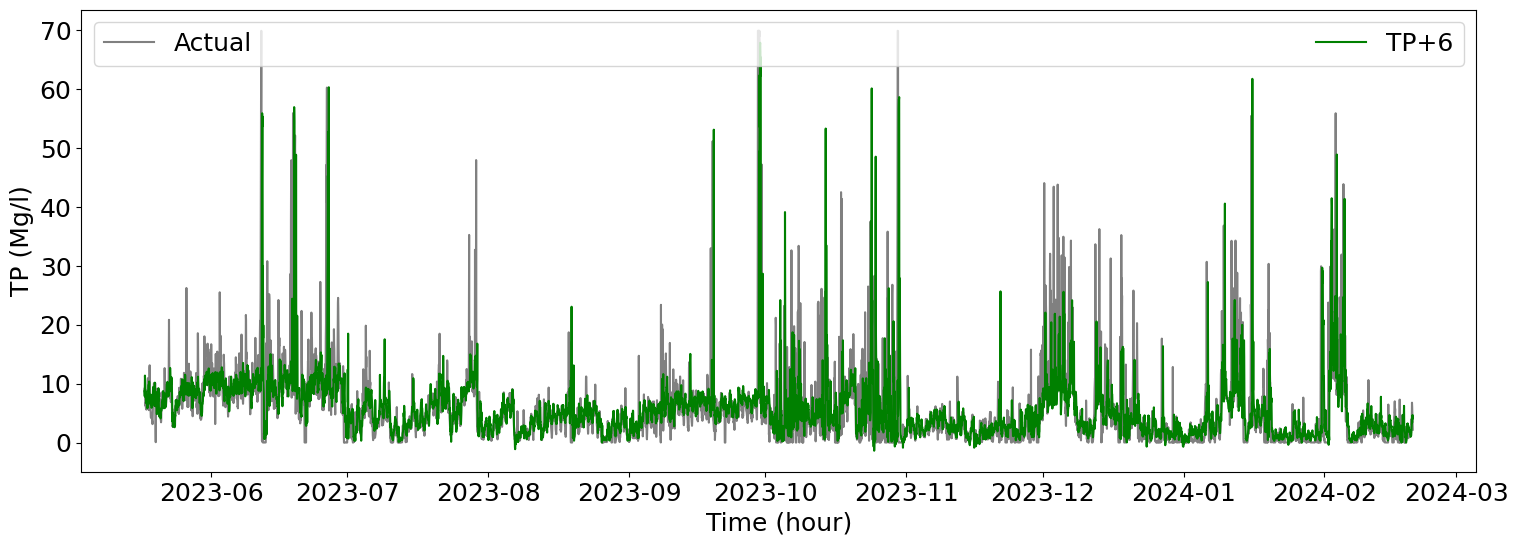

In [19]:
import matplotlib.pyplot as plt

#--------------------------------------------------------------------
#select the feature, and the forcast length to compare:
feature = 'TP'
forcastlength = 6
#--------------------------------------------------------------------

TS = f'{feature}+{forcastlength}'
#linier graph for Test section
time=y_test.index
plt.rcParams.update({'font.size': 18})
fig, ax1 = plt.subplots(figsize=(18,6), )

plt.plot(time,y_test[TS], color = 'gray', label = 'Actual')
plt.plot(time,dfxgb_y_pred[TS], color = 'green', label = TS)

plt.xlabel("Time (hour)")
plt.ylabel(f'{feature} (Mg/l)')
plt.legend(loc='upper center', mode='expand',ncol=5)
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

fetures = ['TOC','TN','TP','SS']

for feature in fetures:
    for i in range(1,7,1):
        index = f'{feature}+{i}'
        xgb_stat = mean_squared_error(y_test[index], dfxgb_y_pred[index],squared=False) #Just copy one of the functions in the first line for different comparisions
        print(f'{index}: {xgb_stat}')
    print('--------------------------')

TOC+1: 26.166923765957108
TOC+2: 33.77098929551798
TOC+3: 34.49224204643485
TOC+4: 35.13618057641602
TOC+5: 36.18141588868
TOC+6: 37.98108867240196
--------------------------
TN+1: 5.106816570681121
TN+2: 7.356824505733283
TN+3: 7.942753487354716
TN+4: 7.38365573480292
TN+5: 7.714535620801518
TN+6: 8.260180176419292
--------------------------
TP+1: 4.152290461355811
TP+2: 5.103945946927055
TP+3: 5.786702518147654
TP+4: 6.0628467295298965
TP+5: 6.457728738134143
TP+6: 6.563032586433483
--------------------------
SS+1: 0.2723790109039844
SS+2: 0.35528370292201905
SS+3: 0.39269120575522953
SS+4: 0.4200762306891735
SS+5: 0.4695657700439277
SS+6: 0.4807576171341054
--------------------------


c:\Users\chga\source\repos\MLHackathon24_PollutionPatterns\pollutionpatterns\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\chga\source\repos\MLHackathon24_PollutionPatterns\pollutionpatterns\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\chga\source\repos\MLHackathon24_PollutionPatterns\pollutionpatterns\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\chga\source\repos\MLHackathon24_PollutionPatte